# <font style="font-family:roboto;color:#455e6c"> Data analysis and workflows in Materials science </font>  

## <font style="font-family:roboto;color:#455e6c"> Part III: Customising your workflow </font>  

So far we have covered python and simulation workflows with LAMMPS. We have seen how pyiron can help your data analysis. Now we will consider a case when you have a workflow which you program in python, and then convert to a pyiron custom Job. Converting it to Job ensures that you can use a number of powerful features that pyiron provides, such as data management, job management and so on.

In this example, we start from a datafile in csv format. The file containes data from a tensile test of typical S355 (material number: 1.0577) structural steel (designation of steel according to DIN EN 10025-2:2019). The data were generated in the frame of the digitization project Innovationplatform MaterialDigital (PMD) which, amongst other activities, aims to store data in a semantically and machine understandable way. Therefore, data structuring and data formats are focused in addition to aspects in the field of material science and engineering (MSE). 

First, we will use python to extract the Youngs modulus from the data. Then we will make a pyiron Job from it. 

As usual we start with some libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We will read in the first csv file using pandas. Note that we use a number of other keyword arguments.  

In [33]:
df = pd.read_csv("tensile_test_data_1.csv", delimiter=";", header=[0,1], decimal=',')

In [34]:
df

,Time,Crosshead separation,Load,Extensometer elongation
,(sec),(mm),(kN),(%)
0,0.00000,0.00000,0.25459,0.05855
1,0.10000,0.00104,0.25510,0.05854
2,0.20000,0.00284,0.25807,0.05860
3,0.30000,0.00544,0.26516,0.05864
4,0.40000,0.00888,0.28904,0.05871
...,...,...,...,...
1483,129.41400,26.54196,36.76555,NaN
1484,129.41600,26.54304,34.26645,NaN
1485,129.41800,26.54432,31.69191,NaN


As expected from a tensile test, the data contains the load and the elongation. First we need to convert the load to stress in MPa. The area in $mm^2$ of the sample is 120.636.

In [35]:
df['Stress'] = df['Load']*1000/120.636

We calculated the stress and added it as a new column. Note that we converted kN to N. Now we can plot this data.

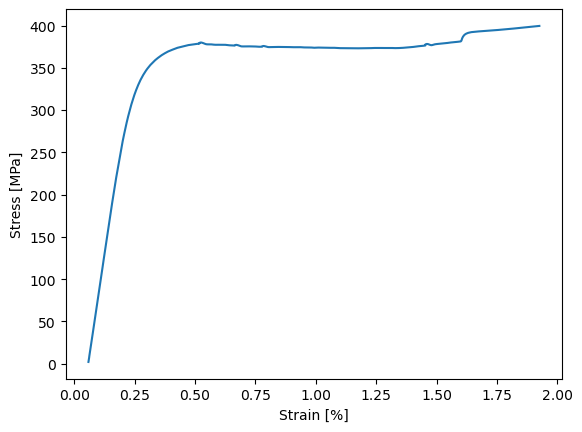

In [36]:
plt.plot(df['Extensometer elongation'], df['Stress'])
plt.xlabel("Strain [%]");
plt.ylabel("Stress [MPa]");

That looks great, we can find the Youngs modulus from the elastic part. For this we will consider the data upto 0.25% Strain.

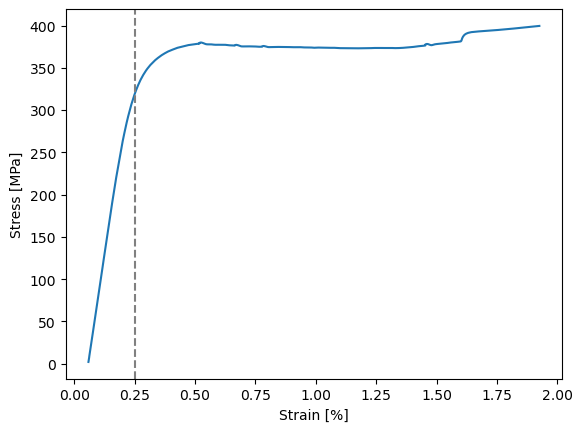

In [39]:
plt.plot(df['Extensometer elongation'], df['Stress'])
plt.xlabel("Strain [%]");
plt.ylabel("Stress [MPa]");
plt.axvline(0.25, color="gray", ls='dashed')

Now we need to find the index of the Strain value closest to 0.25. We extract the values and work with numpy arrays

In [60]:
strain = df['Extensometer elongation'].values.flatten()
stress = df['Stress'].values.flatten()

In [62]:
np.argsort(np.abs(np.array(strain)-0.25))[0]

370

We need to consider stress and strain upto the 370th index. We can plot and confirm this.

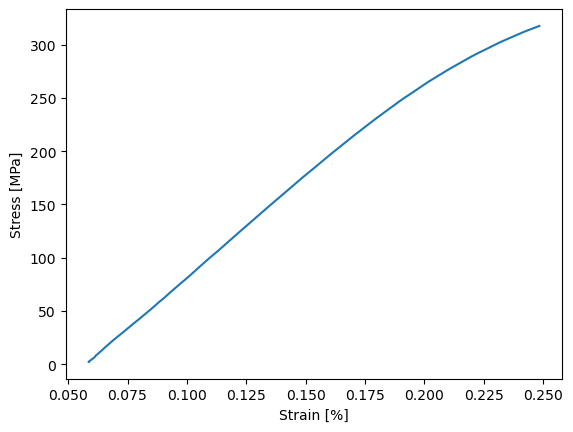

In [63]:
plt.plot(strain[:370], stress[:370])
plt.xlabel("Strain [%]");
plt.ylabel("Stress [MPa]");

Now all we need to do is to fit this data to a straight line and get the slope

In [64]:
fit = np.polyfit(strain[:170], stress[:170], 1)
fit

array([1921.31953891, -110.75971294])

We do some unit conversions to change strain to a ratio, and convert to GPa

In [65]:
fit[0]*(1/0.01)/1000

192.13195389079922

Great we have successfully managed to calculate the Youngs modulus. But if we have to now calculate the results again for a different set of data (repetition of the experiment), we will have to redo the whole code again. Furthermore we would have to take care of naming files and folders in an appropriate manner. We will tackle this problem using pyiron. We will create a Job class, similar to ones we saw before.

Since we use python for our analysis we will use a `PythonTemplateJob` from pyiron. These are easy to use templates for convenience.

In [73]:
from pyiron_base import PythonTemplateJob
from pyiron import Project

Note that we also used `pyiron_base` instead of `pyiron`. This module provides the core functionality of pyiron. Now we will make a class.

In [82]:
class YoungsModulusJob(PythonTemplateJob):
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
    
    def run_static(self):
        print("run")
    
    

That is all the code needed to manage a Job. Pyiron provides a lot of different things to manage your work. For example, all pyiron jobs are saved in `hdf5` format on the disk with all input and output parameters. This means that you can always reproduce your calculation without losing information. To facilitate this, pyiron provides `job.input` and `job.output`. Whatever you save in these fields will be automatically stored. We will customise the class above to suit our needs.

We will:

- Add necessary inputs
- Add necessary outputs
- Function to process data
- Function to calculate Youngs modulus
- Function to plot the Stress-strain curve

In [90]:
class YoungsModulusJob(PythonTemplateJob):
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        #now we define our input parameters
        #first one, input file
        self.input.filename = None
        #then the sample area
        self.input.area = None
        #we should also take a strain cutoff to identify the linear region
        self.input.strain_cutoff = 0.25
    
    def read_input(self):
        """
        My custom function to read an input file and process it
        """
        df = pd.read_csv(self.input.filename, delimiter=";", header=[0,1], decimal=',')
        df['Stress'] = df['Load']*1000/120.636
        self.input.load = df['Load']*1000
        self.input.strain = df['Extensometer elongation'].values.flatten()
        self.input.stress = df['Stress'].values.flatten()
        #note that prefixed some values with self.input, these will be stored
    
    def calculate_youngs_modulus(self):
        """
        My custom job to calculate Youngs modulus
        """
        arg = np.argsort(np.abs(np.array(self.input.strain)-self.input.strain_cutoff))[0]
        fit = np.polyfit(self.input.strain[:arg], self.input.stress[:arg], 1)
        self.output.youngs_modulus = fit[0]*(1/0.01)/1000
    
    def plot(self):
        """
        Function to plot
        """
        plt.plot(self.input.strain, self.input.stress)
        plt.xlabel("Strain [%]");
        plt.ylabel("Stress [MPa]");
    
    def run_static(self):
        """
        And the last function, this tells pyiron what to execute
        """
        #first read input
        self.read_input()
        #then calculate 
        self.calculate_youngs_modulus()

The class is complete now. We can try it out.

In [91]:
pr = Project("custom_project_0")

In [95]:
job=pr.create_job(job_type=YoungsModulusJob, job_name='y1', delete_existing_job=True)

In [96]:
job.input.filename = "tensile_test_data_1.csv"
job.run()

The job y1 was saved and received the ID: 16


First we can plot and see the curves

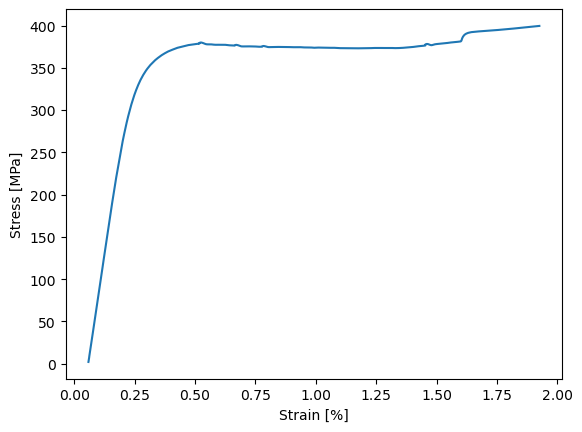

In [97]:
job.plot()

Now we can check the results

In [98]:
job.output

DataContainer({'youngs_modulus': 176.7585378389848})

## References

- [Steel tensile test dataset](https://zenodo.org/record/6778336#.ZEKTVHbP2Uk)